## 1. Import Libraries

In [1]:
# Standard libraries
import os
import sys
import json
import time
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any

# Data handling
import numpy as np
import pandas as pd

# Image processing
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress tracking
from tqdm.auto import tqdm

# Deep learning
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF

# Configuration
import yaml

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ Libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce MX450


## 2. Setup Paths and Load Configuration

In [2]:
# Project paths
project_root = Path(r'd:\Projects\AI-Virtual-TryOn')
dataset_root = project_root / 'data' / 'zalando-hd-resized'
processed_dir = project_root / 'data' / 'processed'
output_dir = project_root / 'outputs' / 'dataset'
output_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Project Root: {project_root}")
print(f"📁 Dataset Root: {dataset_root}")
print(f"📁 Processed Data: {processed_dir}")
print(f"📁 Output Directory: {output_dir}")

# Load configurations
with open(processed_dir / 'preprocessing_config.yaml', 'r') as f:
    preprocess_config = yaml.load(f, Loader=yaml.FullLoader)

with open(project_root / 'outputs' / 'cloth_agnostic' / 'cloth_agnostic_config.json', 'r') as f:
    ca_config = json.load(f)

print("\n✅ Loaded configurations")

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🖥️ Using device: {device}")

# Load dataset catalogs
train_catalog = pd.read_csv(processed_dir / 'train_catalog.csv')
val_catalog = pd.read_csv(processed_dir / 'val_catalog.csv')
test_catalog = pd.read_csv(processed_dir / 'test_catalog.csv')

print(f"\n📊 Dataset: {len(train_catalog)} train, {len(val_catalog)} val, {len(test_catalog)} test")

📁 Project Root: d:\Projects\AI-Virtual-TryOn
📁 Dataset Root: d:\Projects\AI-Virtual-TryOn\data\zalando-hd-resized
📁 Processed Data: d:\Projects\AI-Virtual-TryOn\data\processed
📁 Output Directory: d:\Projects\AI-Virtual-TryOn\outputs\dataset

✅ Loaded configurations

🖥️ Using device: cuda

📊 Dataset: 10482 train, 1165 val, 2032 test


## 3. Define Helper Functions

Reuse functions from previous notebooks.

In [3]:
def load_pose_keypoints(json_path: str) -> np.ndarray:
    """Load pose keypoints from OpenPose JSON."""
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    if 'people' in data and len(data['people']) > 0:
        pose_keypoints = data['people'][0]['pose_keypoints_2d']
        keypoints = np.array(pose_keypoints).reshape(-1, 3)
        return keypoints
    else:
        return np.zeros((25, 3))


def create_pose_heatmaps(keypoints: np.ndarray, 
                        image_size: Tuple[int, int],
                        sigma: float = 3.0) -> np.ndarray:
    """Create Gaussian heatmaps from keypoints."""
    h, w = image_size
    heatmaps = np.zeros((18, h, w), dtype=np.float32)  # 18 channels
    
    y_grid, x_grid = np.ogrid[:h, :w]
    
    for i in range(18):  # Only first 18 keypoints
        x, y, conf = keypoints[i]
        if conf > 0.1:
            x, y = int(x), int(y)
            if 0 <= x < w and 0 <= y < h:
                heatmap = np.exp(-((x_grid - x)**2 + (y_grid - y)**2) / (2 * sigma**2))
                heatmaps[i] = heatmap * conf
    
    return heatmaps


def parsing_to_onehot(parsing: np.ndarray, num_classes: int = 20) -> np.ndarray:
    """Convert parsing mask to one-hot encoding."""
    h, w = parsing.shape
    onehot = np.zeros((num_classes, h, w), dtype=np.float32)
    
    for i in range(num_classes):
        onehot[i][parsing == i] = 1.0
    
    return onehot


def create_cloth_agnostic_mask(parsing: np.ndarray,
                               garment_classes: List[int] = [5, 7]) -> np.ndarray:
    """Create cloth-agnostic mask by removing garment."""
    mask = np.ones_like(parsing, dtype=np.uint8)
    
    for cls_id in garment_classes:
        mask[parsing == cls_id] = 0
    
    return mask


print("✅ Helper functions defined")

✅ Helper functions defined


## 4. Data Augmentation Pipeline

In [4]:
class VITONAugmentation:
    """
    Data augmentation for virtual try-on.
    Applies synchronized augmentation to all modalities.
    """
    
    def __init__(self, 
                 is_train: bool = True,
                 horizontal_flip_prob: float = 0.5,
                 color_jitter_prob: float = 0.3):
        self.is_train = is_train
        self.horizontal_flip_prob = horizontal_flip_prob
        self.color_jitter_prob = color_jitter_prob
        
        # Color jitter for RGB images only
        self.color_jitter = T.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1
        )
    
    def __call__(self, data: Dict[str, Any]) -> Dict[str, Any]:
        """
        Apply augmentation to all data modalities.
        """
        if not self.is_train:
            return data
        
        # Horizontal flip (synchronized across all modalities)
        if torch.rand(1).item() < self.horizontal_flip_prob:
            data = self._horizontal_flip(data)
        
        # Color jitter (only for RGB images)
        if torch.rand(1).item() < self.color_jitter_prob:
            data = self._apply_color_jitter(data)
        
        return data
    
    def _horizontal_flip(self, data: Dict[str, Any]) -> Dict[str, Any]:
        """Apply horizontal flip to all modalities."""
        # Flip image tensors
        for key in ['person_image', 'cloth_image', 'cloth_agnostic', 
                    'pose_map', 'parsing_onehot', 'ca_mask']:
            if key in data:
                data[key] = TF.hflip(data[key])
        
        # Swap left/right keypoints if needed
        # This would require more complex logic for pose keypoints
        
        return data
    
    def _apply_color_jitter(self, data: Dict[str, Any]) -> Dict[str, Any]:
        """Apply color jitter to RGB images only."""
        for key in ['person_image', 'cloth_image']:
            if key in data:
                data[key] = self.color_jitter(data[key])
        
        return data


print("✅ Augmentation pipeline defined")

✅ Augmentation pipeline defined


## 5. VITONDataset Class

In [5]:
class VITONDataset(Dataset):
    """
    PyTorch Dataset for Virtual Try-On (VITON-HD).
    
    Returns:
    - person_image: [3, H, W] normalized RGB
    - cloth_image: [3, H, W] normalized RGB
    - cloth_agnostic: [3, H, W] normalized RGB (with garment removed)
    - pose_map: [18, H, W] pose heatmaps
    - parsing_onehot: [20, H, W] parsing one-hot
    - ca_mask: [1, H, W] cloth-agnostic mask
    """
    
    def __init__(self,
                 catalog: pd.DataFrame,
                 image_size: Tuple[int, int] = (1024, 768),
                 is_train: bool = True,
                 augmentation: Optional[VITONAugmentation] = None):
        """
        Args:
            catalog: DataFrame with file paths
            image_size: (height, width)
            is_train: Whether this is training set
            augmentation: Augmentation pipeline
        """
        self.catalog = catalog.reset_index(drop=True)
        self.image_size = image_size
        self.is_train = is_train
        self.augmentation = augmentation
        
        # Normalization parameters
        self.mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
        self.std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
        
        # Garment classes to remove for cloth-agnostic
        self.upper_body_classes = [5, 7]  # Upper-clothes, Coat
    
    def __len__(self) -> int:
        return len(self.catalog)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Load and preprocess a single sample.
        """
        row = self.catalog.iloc[idx]
        
        # Load images
        person_img = np.array(Image.open(row['person_image']))
        cloth_img = np.array(Image.open(row['cloth_image']))
        parsing = np.array(Image.open(row['parse_mask']))
        keypoints = load_pose_keypoints(row['pose_json'])
        
        # Create cloth-agnostic RGB
        ca_mask = create_cloth_agnostic_mask(parsing, self.upper_body_classes)
        ca_rgb = person_img.copy()
        ca_rgb[ca_mask == 0] = 128  # Gray fill
        
        # Create pose heatmaps
        pose_heatmaps = create_pose_heatmaps(keypoints, self.image_size)
        
        # Create parsing one-hot
        parsing_onehot = parsing_to_onehot(parsing, num_classes=20)
        
        # Convert to tensors
        person_tensor = torch.from_numpy(person_img).permute(2, 0, 1).float() / 255.0
        cloth_tensor = torch.from_numpy(cloth_img).permute(2, 0, 1).float() / 255.0
        ca_tensor = torch.from_numpy(ca_rgb).permute(2, 0, 1).float() / 255.0
        pose_tensor = torch.from_numpy(pose_heatmaps).float()
        parsing_tensor = torch.from_numpy(parsing_onehot).float()
        ca_mask_tensor = torch.from_numpy(ca_mask).unsqueeze(0).float()
        
        # Normalize RGB images to [-1, 1]
        person_tensor = (person_tensor - self.mean) / self.std
        cloth_tensor = (cloth_tensor - self.mean) / self.std
        ca_tensor = (ca_tensor - self.mean) / self.std
        
        # Create data dictionary
        data = {
            'person_image': person_tensor,        # [3, H, W]
            'cloth_image': cloth_tensor,          # [3, H, W]
            'cloth_agnostic': ca_tensor,          # [3, H, W]
            'pose_map': pose_tensor,              # [18, H, W]
            'parsing_onehot': parsing_tensor,     # [20, H, W]
            'ca_mask': ca_mask_tensor,            # [1, H, W]
            'id': row['id']
        }
        
        # Apply augmentation
        if self.augmentation is not None:
            data = self.augmentation(data)
        
        return data


print("✅ VITONDataset class defined")

✅ VITONDataset class defined


## 6. Create DataLoaders

In [6]:
# Create augmentation pipelines
train_augmentation = VITONAugmentation(
    is_train=True,
    horizontal_flip_prob=0.5,
    color_jitter_prob=0.3
)

val_augmentation = VITONAugmentation(
    is_train=False
)

# Create datasets
train_dataset = VITONDataset(
    catalog=train_catalog,
    image_size=(1024, 768),
    is_train=True,
    augmentation=train_augmentation
)

val_dataset = VITONDataset(
    catalog=val_catalog,
    image_size=(1024, 768),
    is_train=False,
    augmentation=val_augmentation
)

test_dataset = VITONDataset(
    catalog=test_catalog,
    image_size=(1024, 768),
    is_train=False,
    augmentation=val_augmentation
)

print("✅ Datasets created")
print(f"   Train: {len(train_dataset):,} samples")
print(f"   Val: {len(val_dataset):,} samples")
print(f"   Test: {len(test_dataset):,} samples")

# Create DataLoaders
# Note: num_workers=0 for Windows compatibility
batch_size = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Windows compatibility
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=False
)

print("\n✅ DataLoaders created")
print(f"   Train: {len(train_loader):,} batches")
print(f"   Val: {len(val_loader):,} batches")
print(f"   Test: {len(test_loader):,} batches")
print(f"   Batch size: {batch_size}")

✅ Datasets created
   Train: 10,482 samples
   Val: 1,165 samples
   Test: 2,032 samples

✅ DataLoaders created
   Train: 2,620 batches
   Val: 292 batches
   Test: 508 batches
   Batch size: 4


## 7. Test Single Sample

In [7]:
# Test loading a single sample
sample = train_dataset[0]

print("="*70)
print("🔍 SINGLE SAMPLE TEST")
print("="*70)

print(f"\n📊 Sample ID: {sample['id']}")
print(f"\n📊 Data shapes:")
for key, value in sample.items():
    if isinstance(value, torch.Tensor):
        print(f"   {key:25s}: {tuple(value.shape)}")
        print(f"      dtype: {value.dtype}, range: [{value.min():.3f}, {value.max():.3f}]")

# Calculate total channels
total_channels = (
    sample['cloth_agnostic'].shape[0] +  # 3
    sample['pose_map'].shape[0] +         # 18
    sample['parsing_onehot'].shape[0]     # 20
)

print(f"\n💡 Total model input channels: {total_channels}")
print(f"   - Cloth-agnostic RGB: {sample['cloth_agnostic'].shape[0]}")
print(f"   - Pose map: {sample['pose_map'].shape[0]}")
print(f"   - Parsing one-hot: {sample['parsing_onehot'].shape[0]}")

print("\n" + "="*70)
print("\n✅ Single sample loaded successfully!")

🔍 SINGLE SAMPLE TEST

📊 Sample ID: 10726_00

📊 Data shapes:
   person_image             : (3, 1024, 768)
      dtype: torch.float32, range: [-1.000, 1.000]
   cloth_image              : (3, 1024, 768)
      dtype: torch.float32, range: [-0.976, 1.000]
   cloth_agnostic           : (3, 1024, 768)
      dtype: torch.float32, range: [-1.000, 1.000]
   pose_map                 : (18, 1024, 768)
      dtype: torch.float32, range: [0.000, 0.945]
   parsing_onehot           : (20, 1024, 768)
      dtype: torch.float32, range: [0.000, 1.000]
   ca_mask                  : (1, 1024, 768)
      dtype: torch.float32, range: [0.000, 1.000]

💡 Total model input channels: 41
   - Cloth-agnostic RGB: 3
   - Pose map: 18
   - Parsing one-hot: 20


✅ Single sample loaded successfully!


## 8. Test Batch Loading

In [8]:
# Load a batch
print("="*70)
print("📦 BATCH LOADING TEST")
print("="*70)

batch = next(iter(train_loader))

print(f"\n📊 Batch shapes:")
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        print(f"   {key:25s}: {tuple(value.shape)}")
        print(f"      dtype: {value.dtype}, device: {value.device}")

print(f"\n📊 Memory usage:")
total_memory = 0
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        mem = value.element_size() * value.nelement() / 1024**2  # MB
        total_memory += mem
        print(f"   {key:25s}: {mem:.2f} MB")

print(f"   {'Total':25s}: {total_memory:.2f} MB")

print("\n" + "="*70)
print("\n✅ Batch loaded successfully!")

📦 BATCH LOADING TEST

📊 Batch shapes:
   person_image             : (4, 3, 1024, 768)
      dtype: torch.float32, device: cpu
   cloth_image              : (4, 3, 1024, 768)
      dtype: torch.float32, device: cpu
   cloth_agnostic           : (4, 3, 1024, 768)
      dtype: torch.float32, device: cpu
   pose_map                 : (4, 18, 1024, 768)
      dtype: torch.float32, device: cpu
   parsing_onehot           : (4, 20, 1024, 768)
      dtype: torch.float32, device: cpu
   ca_mask                  : (4, 1, 1024, 768)
      dtype: torch.float32, device: cpu

📊 Memory usage:
   person_image             : 36.00 MB
   cloth_image              : 36.00 MB
   cloth_agnostic           : 36.00 MB
   pose_map                 : 216.00 MB
   parsing_onehot           : 240.00 MB
   ca_mask                  : 12.00 MB
   Total                    : 576.00 MB


✅ Batch loaded successfully!


## 9. Visualize Batch

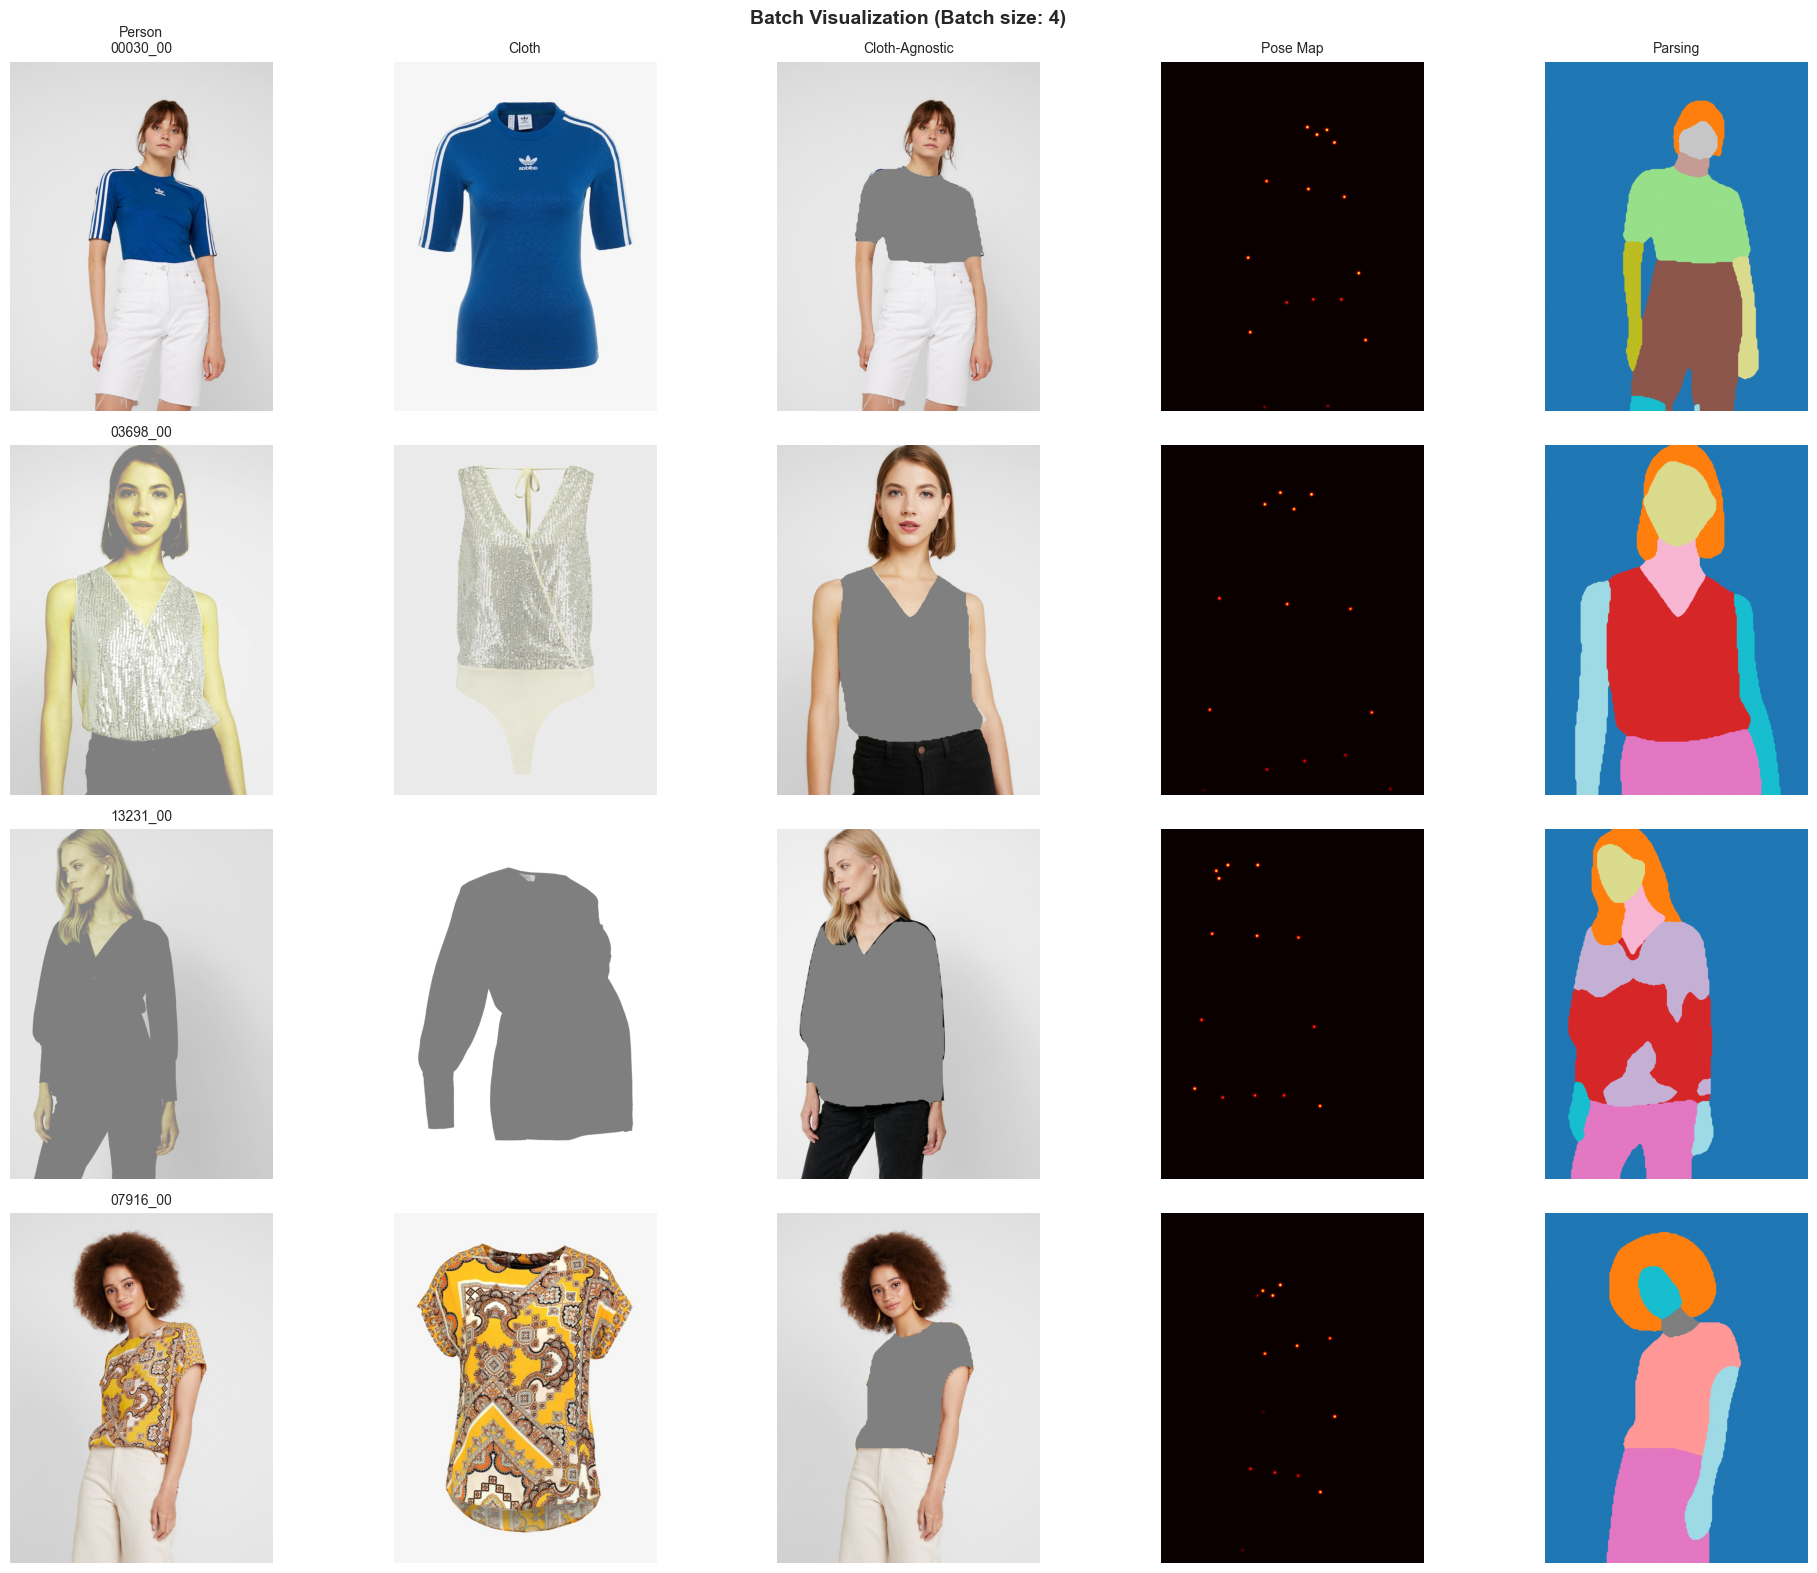

✅ Batch visualization saved


In [9]:
def denormalize(tensor: torch.Tensor) -> torch.Tensor:
    """Denormalize from [-1, 1] to [0, 1]."""
    return tensor * 0.5 + 0.5


# Visualize batch
fig, axes = plt.subplots(4, 5, figsize=(20, 16))

for i in range(4):  # Show 4 samples from batch
    # Person image
    person = denormalize(batch['person_image'][i]).permute(1, 2, 0).cpu().numpy()
    axes[i, 0].imshow(np.clip(person, 0, 1))
    axes[i, 0].set_title(f"Person\n{batch['id'][i]}" if i == 0 else batch['id'][i], fontsize=10)
    axes[i, 0].axis('off')
    
    # Cloth image
    cloth = denormalize(batch['cloth_image'][i]).permute(1, 2, 0).cpu().numpy()
    axes[i, 1].imshow(np.clip(cloth, 0, 1))
    axes[i, 1].set_title('Cloth' if i == 0 else '', fontsize=10)
    axes[i, 1].axis('off')
    
    # Cloth-agnostic
    ca = denormalize(batch['cloth_agnostic'][i]).permute(1, 2, 0).cpu().numpy()
    axes[i, 2].imshow(np.clip(ca, 0, 1))
    axes[i, 2].set_title('Cloth-Agnostic' if i == 0 else '', fontsize=10)
    axes[i, 2].axis('off')
    
    # Pose map (max across channels)
    pose = torch.max(batch['pose_map'][i], dim=0)[0].cpu().numpy()
    axes[i, 3].imshow(pose, cmap='hot')
    axes[i, 3].set_title('Pose Map' if i == 0 else '', fontsize=10)
    axes[i, 3].axis('off')
    
    # Parsing (argmax to get class labels)
    parsing = torch.argmax(batch['parsing_onehot'][i], dim=0).cpu().numpy()
    axes[i, 4].imshow(parsing, cmap='tab20')
    axes[i, 4].set_title('Parsing' if i == 0 else '', fontsize=10)
    axes[i, 4].axis('off')

plt.suptitle(f'Batch Visualization (Batch size: {batch_size})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'batch_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Batch visualization saved")

## 10. Timing Benchmark

In [10]:
print("="*70)
print("⏱️ DATALOADER TIMING BENCHMARK")
print("="*70)

# Benchmark loading speed
n_batches = 20
times = []

print(f"\n🔄 Loading {n_batches} batches...\n")

for i, batch in enumerate(tqdm(train_loader, total=n_batches, desc="Timing")):
    start = time.time()
    
    # Simulate moving to GPU
    if torch.cuda.is_available():
        for key in batch:
            if isinstance(batch[key], torch.Tensor):
                batch[key] = batch[key].to(device)
    
    times.append(time.time() - start)
    
    if i >= n_batches - 1:
        break

times = np.array(times)

print(f"\n📊 Timing Statistics:")
print("-" * 50)
print(f"   Mean time per batch: {times.mean()*1000:.2f} ms")
print(f"   Std time per batch: {times.std()*1000:.2f} ms")
print(f"   Min time per batch: {times.min()*1000:.2f} ms")
print(f"   Max time per batch: {times.max()*1000:.2f} ms")

# Calculate samples per second
samples_per_second = batch_size / times.mean()
print(f"\n⚡ Throughput: {samples_per_second:.2f} samples/second")

# Estimate epoch time
epoch_time = len(train_loader) * times.mean() / 60  # minutes
print(f"📊 Estimated epoch time: {epoch_time:.2f} minutes")

print("\n" + "="*70)
print("\n✅ Timing benchmark complete!")

⏱️ DATALOADER TIMING BENCHMARK

🔄 Loading 20 batches...



Timing:   0%|          | 0/20 [00:00<?, ?it/s]


📊 Timing Statistics:
--------------------------------------------------
   Mean time per batch: 341.79 ms
   Std time per batch: 52.97 ms
   Min time per batch: 256.79 ms
   Max time per batch: 461.82 ms

⚡ Throughput: 11.70 samples/second
📊 Estimated epoch time: 14.92 minutes


✅ Timing benchmark complete!


## 11. Memory Analysis

In [11]:
print("="*70)
print("💾 MEMORY ANALYSIS")
print("="*70)

# Single sample memory
sample = train_dataset[0]
sample_memory = 0

print(f"\n📊 Single Sample Memory:")
print("-" * 50)
for key, value in sample.items():
    if isinstance(value, torch.Tensor):
        mem = value.element_size() * value.nelement() / 1024**2
        sample_memory += mem
        print(f"   {key:25s}: {mem:.2f} MB")

print(f"   {'Total':25s}: {sample_memory:.2f} MB")

# Batch memory
batch = next(iter(train_loader))
batch_memory = 0

print(f"\n📊 Batch Memory (batch_size={batch_size}):")
print("-" * 50)
for key, value in batch.items():
    if isinstance(value, torch.Tensor):
        mem = value.element_size() * value.nelement() / 1024**2
        batch_memory += mem
        print(f"   {key:25s}: {mem:.2f} MB")

print(f"   {'Total':25s}: {batch_memory:.2f} MB")

# GPU memory if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
    # Move batch to GPU
    for key in batch:
        if isinstance(batch[key], torch.Tensor):
            batch[key] = batch[key].to(device)
    
    gpu_memory = torch.cuda.memory_allocated() / 1024**2
    gpu_reserved = torch.cuda.memory_reserved() / 1024**2
    
    print(f"\n📊 GPU Memory:")
    print("-" * 50)
    print(f"   Allocated: {gpu_memory:.2f} MB")
    print(f"   Reserved: {gpu_reserved:.2f} MB")
    print(f"   Total GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.2f} MB")

print("\n" + "="*70)
print("\n✅ Memory analysis complete!")

💾 MEMORY ANALYSIS

📊 Single Sample Memory:
--------------------------------------------------
   person_image             : 9.00 MB
   cloth_image              : 9.00 MB
   cloth_agnostic           : 9.00 MB
   pose_map                 : 54.00 MB
   parsing_onehot           : 60.00 MB
   ca_mask                  : 3.00 MB
   Total                    : 144.00 MB

📊 Batch Memory (batch_size=4):
--------------------------------------------------
   person_image             : 36.00 MB
   cloth_image              : 36.00 MB
   cloth_agnostic           : 36.00 MB
   pose_map                 : 216.00 MB
   parsing_onehot           : 240.00 MB
   ca_mask                  : 12.00 MB
   Total                    : 576.00 MB

📊 GPU Memory:
--------------------------------------------------
   Allocated: 576.00 MB
   Reserved: 576.00 MB
   Total GPU: 2047.75 MB


✅ Memory analysis complete!


## 12. Save Dataset Configuration

In [12]:
# Create dataset configuration
dataset_config = {
    'dataset': {
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'total_samples': len(train_dataset) + len(val_dataset) + len(test_dataset)
    },
    'dataloader': {
        'batch_size': batch_size,
        'num_workers': 0,
        'pin_memory': torch.cuda.is_available(),
        'train_batches': len(train_loader),
        'val_batches': len(val_loader),
        'test_batches': len(test_loader)
    },
    'data_format': {
        'image_size': list(train_dataset.image_size),
        'channels': {
            'person_image': 3,
            'cloth_image': 3,
            'cloth_agnostic': 3,
            'pose_map': 18,
            'parsing_onehot': 20,
            'ca_mask': 1,
            'total_input': 41
        },
        'normalization': {
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'range': [-1, 1]
        }
    },
    'augmentation': {
        'horizontal_flip_prob': 0.5,
        'color_jitter_prob': 0.3
    },
    'performance': {
        'mean_batch_time_ms': float(times.mean() * 1000),
        'throughput_samples_per_sec': float(samples_per_second),
        'estimated_epoch_time_min': float(epoch_time),
        'single_sample_memory_mb': float(sample_memory),
        'batch_memory_mb': float(batch_memory)
    }
}

# Save configuration
config_path = output_dir / 'dataset_config.json'
with open(config_path, 'w') as f:
    json.dump(dataset_config, f, indent=2)

print("="*70)
print("💾 DATASET CONFIGURATION SAVED")
print("="*70)

print(f"\n📄 Config saved to: {config_path}")

print(f"\n📊 Summary:")
print(f"   - Total samples: {dataset_config['dataset']['total_samples']:,}")
print(f"   - Batch size: {dataset_config['dataloader']['batch_size']}")
print(f"   - Input channels: {dataset_config['data_format']['channels']['total_input']}")
print(f"   - Throughput: {dataset_config['performance']['throughput_samples_per_sec']:.2f} samples/sec")
print(f"   - Epoch time: {dataset_config['performance']['estimated_epoch_time_min']:.2f} min")

print("\n" + "="*70)

💾 DATASET CONFIGURATION SAVED

📄 Config saved to: d:\Projects\AI-Virtual-TryOn\outputs\dataset\dataset_config.json

📊 Summary:
   - Total samples: 13,679
   - Batch size: 4
   - Input channels: 41
   - Throughput: 11.70 samples/sec
   - Epoch time: 14.92 min



## 13. Summary

In [13]:
print("="*70)
print("🎉 PYTORCH DATASET & DATALOADER COMPLETE!")
print("="*70)

print("\n✅ Completed Tasks:")
print("   1. ✓ Implemented VITONDataset class")
print("   2. ✓ Created data augmentation pipeline")
print("   3. ✓ Built training, validation, and test DataLoaders")
print("   4. ✓ Tested single sample and batch loading")
print("   5. ✓ Benchmarked loading performance")
print("   6. ✓ Analyzed memory usage")
print("   7. ✓ Saved dataset configuration")

print(f"\n📊 Key Metrics:")
print(f"   - Train samples: {len(train_dataset):,}")
print(f"   - Val samples: {len(val_dataset):,}")
print(f"   - Test samples: {len(test_dataset):,}")
print(f"   - Batch size: {batch_size}")
print(f"   - Input channels: 41 (3 + 18 + 20)")
print(f"   - Throughput: {samples_per_second:.2f} samples/sec")
print(f"   - Epoch time: {epoch_time:.2f} minutes")

print(f"\n📁 Generated Files:")
print(f"   - batch_visualization.png")
print(f"   - dataset_config.json")

print("\n🚀 Ready for Next Steps:")
print("   1. Begin model architecture development")
print("   2. Implement Generator network")
print("   3. Implement Discriminator network")
print("   4. Create training loop with losses")
print("   5. Start model training")

print("\n💡 Key Components Created:")
print("   - VITONDataset: Complete PyTorch Dataset")
print("     * Load all modalities (person, cloth, parsing, pose)")
print("     * Generate cloth-agnostic representation")
print("     * Create multi-channel input (41 channels)")
print("     * Support data augmentation")
print("   - VITONAugmentation: Synchronized augmentation")
print("     * Horizontal flip (50% probability)")
print("     * Color jitter (30% probability)")
print("   - DataLoaders: Optimized batch loading")
print("     * Windows compatible (num_workers=0)")
print("     * GPU memory pinning enabled")
print("     * Efficient batch processing")

print("\n" + "="*70)

print("\n✅ DATASET MODULE READY FOR TRAINING!")
print("="*70)

🎉 PYTORCH DATASET & DATALOADER COMPLETE!

✅ Completed Tasks:
   1. ✓ Implemented VITONDataset class
   2. ✓ Created data augmentation pipeline
   3. ✓ Built training, validation, and test DataLoaders
   4. ✓ Tested single sample and batch loading
   5. ✓ Benchmarked loading performance
   6. ✓ Analyzed memory usage
   7. ✓ Saved dataset configuration

📊 Key Metrics:
   - Train samples: 10,482
   - Val samples: 1,165
   - Test samples: 2,032
   - Batch size: 4
   - Input channels: 41 (3 + 18 + 20)
   - Throughput: 11.70 samples/sec
   - Epoch time: 14.92 minutes

📁 Generated Files:
   - batch_visualization.png
   - dataset_config.json

🚀 Ready for Next Steps:
   1. Begin model architecture development
   2. Implement Generator network
   3. Implement Discriminator network
   4. Create training loop with losses
   5. Start model training

💡 Key Components Created:
   - VITONDataset: Complete PyTorch Dataset
     * Load all modalities (person, cloth, parsing, pose)
     * Generate cloth-a